
# 📊 EDA para Modelo de Ponderación de Métricas (Mercado Libre)

**Fecha de generación:** 2025-08-18 16:08:15

Este notebook implementa un EDA estructurado para servir como insumo del sistema de ponderación solicitado en el challenge.

**Dataset esperado (CSV):**
- Columnas: `user_id`, `role`, `seniority`, `cluster`, `metric_name`, `event_count`

> Nota: Las visualizaciones usan **matplotlib** (sin estilos ni colores específicos).


## 0) Setup y carga de datos

In [8]:

# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mostrar todas las columnas al imprimir dataframes
pd.set_option('display.max_columns', None)

# Ruta del dataset (ajústala si tu archivo tiene otro nombre o ubicación)
CSV_PATH = "data/desafio_ponderadores_metrica.csv"  # Cambiar si es necesario

# Carga
df = pd.read_csv(CSV_PATH)

# Validación rápida
print("Shape:", df.shape)
print(df.head(3))


Shape: (1300, 6)
  user_id      role    seniority               cluster    metric_name  \
0  user_1  Frontend  Semi-Senior  Software Development        commits   
1  user_1  Frontend  Semi-Senior  Software Development  pull_requests   
2  user_1  Frontend  Semi-Senior  Software Development         builds   

   event_count  
0           14  
1           13  
2           16  



## 1) Revisión inicial de los datos

**Objetivo:** validar calidad y consistencia antes de calcular nada.

**Checks:**
- Tipos de columnas
- Valores nulos
- Duplicados
- Cardinalidad de cada campo


In [9]:

print("Tipos de columnas:")
print(df.dtypes)

print("\nValores nulos (conteo):")
print(df.isna().sum())

print("\nDuplicados exactos (filas):", df.duplicated().sum())

print("\nCardinalidad:")
for col in ["user_id", "role", "seniority", "cluster", "metric_name"]:
    print(f" - {col}: {df[col].nunique()} únicos")

# Insight automático simple
dominant_cluster = (
    df.groupby('cluster')['event_count'].sum()
    .sort_values(ascending=False)
    .head(1)
)
total_events = df['event_count'].sum()
dom_name = dominant_cluster.index[0]
dom_share = float(dominant_cluster.iloc[0]) / float(total_events) if total_events else 0.0
print(f"\nInsight: el cluster con mayor volumen es '{dom_name}' con {dom_share:.1%} del total de eventos.")


Tipos de columnas:
user_id        object
role           object
seniority      object
cluster        object
metric_name    object
event_count     int64
dtype: object

Valores nulos (conteo):
user_id        0
role           0
seniority      0
cluster        0
metric_name    0
event_count    0
dtype: int64

Duplicados exactos (filas): 0

Cardinalidad:
 - user_id: 100 únicos
 - role: 4 únicos
 - seniority: 3 únicos
 - cluster: 5 únicos
 - metric_name: 13 únicos

Insight: el cluster con mayor volumen es 'Software Development' con 30.7% del total de eventos.



## 2) Análisis descriptivo de **clusters** (grupos funcionales)

**Métrica:** distribución de `event_count` por `cluster`  
**Salidas:** tabla descriptiva y gráfico de barras  
**Qué buscar:** clusters que concentran la mayoría de eventos y clusters poco utilizados (posible ruido).


,total,media,mediana,desviacion,p25,p75
cluster,,,,,,
Software Development,6760,16.900,17.0,8.303455,10.0,23.0
Data Analysis,5169,17.230,16.5,8.377612,11.0,22.0
Documentation,3490,17.450,17.0,8.444766,10.0,24.0
Collaboration,3316,16.580,16.0,8.287158,10.0,23.0
Automation,3267,16.335,16.0,7.953557,9.0,23.0


cluster
Software Development    4
Data Analysis           3
Automation              2
Collaboration           2
Documentation           2
Name: metricas_unicas, dtype: int64

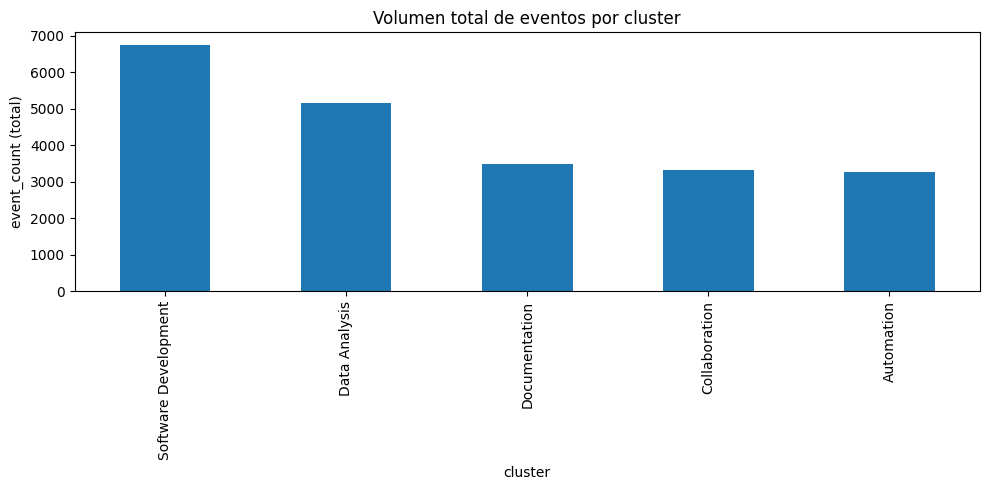

In [10]:

# Agregación por cluster
cluster_agg = (
    df.groupby('cluster')['event_count']
    .agg(['sum', 'mean', 'median', 'std'])
    .rename(columns={'sum':'total', 'mean':'media', 'median':'mediana', 'std':'desviacion'})
    .sort_values('total', ascending=False)
)
# Percentiles adicionales
q = df.groupby('cluster')['event_count'].quantile([0.25, 0.75]).unstack().rename(columns={0.25:'p25', 0.75:'p75'})
cluster_agg = cluster_agg.join(q)

display(cluster_agg)

# Diversidad interna: cuántas métricas únicas por cluster
diversidad = df.groupby('cluster')['metric_name'].nunique().rename('metricas_unicas')
display(diversidad.sort_values(ascending=False))

# Gráfico: barras de volumen total por cluster
plt.figure(figsize=(10, 5))
cluster_agg['total'].plot(kind='bar')
plt.title('Volumen total de eventos por cluster')
plt.xlabel('cluster')
plt.ylabel('event_count (total)')
plt.tight_layout()
plt.show()



**Insight clave (clusters):**  
- El **peso relativo de cada cluster** puede inferirse por su **volumen** (total de eventos) y su **diversidad interna** (cantidad de métricas únicas).  
- Clusters con volumen alto y diversidad alta son candidatos a mayor ponderación a nivel de grupo.



## 3) Métricas dentro de cada cluster

**Métrica:** distribución de `event_count` por `metric_name` **dentro** de cada `cluster`  
**Salidas:** top-N por cluster y gráficos de barras  
**Qué buscar:** skew (pocas métricas dominan), rareza y redundancia.



Top 10 métricas en cluster: Software Development


metric_name
builds           1757
deploys          1720
pull_requests    1657
commits          1626
Name: event_count, dtype: int64

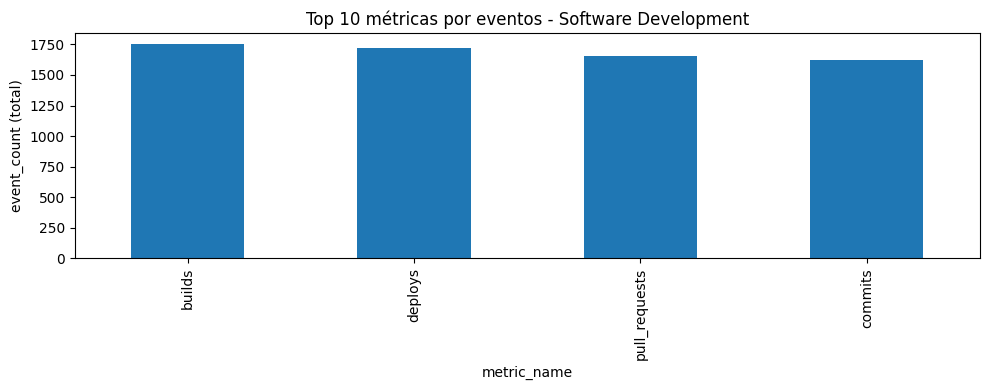


Top 10 métricas en cluster: Data Analysis


metric_name
dashboards_created    1833
queries_executed      1699
notebooks_modified    1637
Name: event_count, dtype: int64

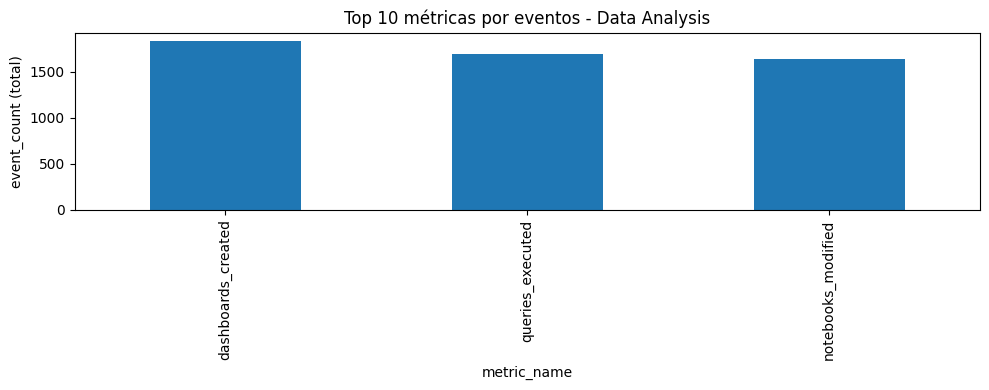


Top 10 métricas en cluster: Documentation


metric_name
docs_edited     1795
docs_created    1695
Name: event_count, dtype: int64

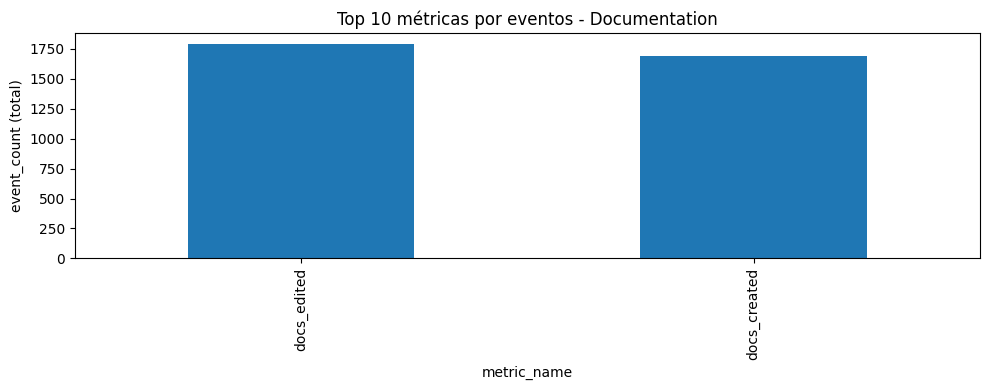


Top 10 métricas en cluster: Automation


metric_name
jobs_scheduled    1702
scripts_run       1565
Name: event_count, dtype: int64

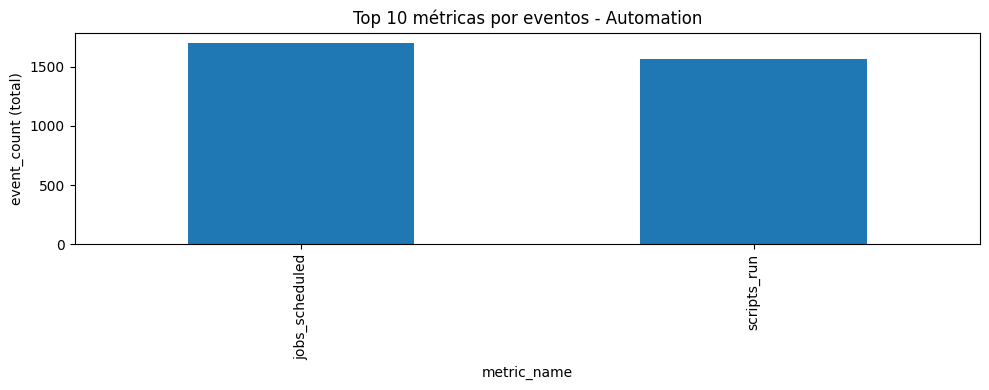


Top 10 métricas en cluster: Collaboration


metric_name
comments_left    1663
files_shared     1653
Name: event_count, dtype: int64

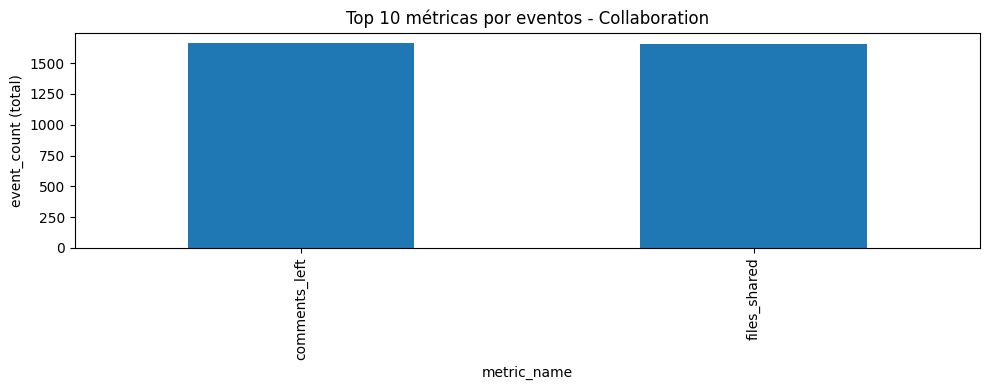


Métricas raras (percentil 10 por cluster):


cluster               cluster               metric_name       
Automation            Automation            scripts_run           1565
Collaboration         Collaboration         files_shared          1653
Data Analysis         Data Analysis         notebooks_modified    1637
Documentation         Documentation         docs_created          1695
Software Development  Software Development  commits               1626
Name: event_count, dtype: int64

In [11]:

TOP_N = 10  # puedes ajustar
clusters = df['cluster'].dropna().unique()

metricas_top_por_cluster = {}

for c in clusters:
    sub = df[df['cluster'] == c]
    agg = sub.groupby('metric_name')['event_count'].sum().sort_values(ascending=False)
    metricas_top_por_cluster[c] = agg.head(TOP_N)
    print(f"\nTop {TOP_N} métricas en cluster: {c}")
    display(agg.head(TOP_N))

    # Gráfico por cluster
    plt.figure(figsize=(10, 4))
    agg.head(TOP_N).plot(kind='bar')
    plt.title(f"Top {TOP_N} métricas por eventos - {c}")
    plt.xlabel('metric_name')
    plt.ylabel('event_count (total)')
    plt.tight_layout()
    plt.show()

# Métricas raras (muy bajo volumen) por cluster
print("\nMétricas raras (percentil 10 por cluster):")
raras = (
    df.groupby(['cluster','metric_name'])['event_count'].sum()
    .groupby(level=0)
    .apply(lambda s: s[s <= s.quantile(0.10)])
)
display(raras)



**Insight clave (métricas por cluster):**  
- Si pocas métricas concentran casi todo el volumen, hay **skew** y conviene **normalizar/penalizar** la frecuencia pura.  
- Métricas que aparecen poco pero son **altamente informativas** (p.ej. discriminan por rol/seniority) pueden recibir mayor peso relativo.



## 4) Análisis por perfil de usuario (**role** y **seniority**)

**Métricas:** eventos agregados por `(role, seniority, cluster)` y `(role, seniority, metric_name)`  
**Salidas:** tablas y mapas de calor con `matplotlib`  
**Qué buscar:** diferencias sistemáticas entre roles y seniorities.


cluster,Automation,Collaboration,Data Analysis,Documentation,Software Development
role,,,,,
Backend,551,484,871,491,1105
Data Analyst,644,661,998,694,1311
Data Engineer,1046,1052,1699,1102,2226
Frontend,1026,1119,1601,1203,2118


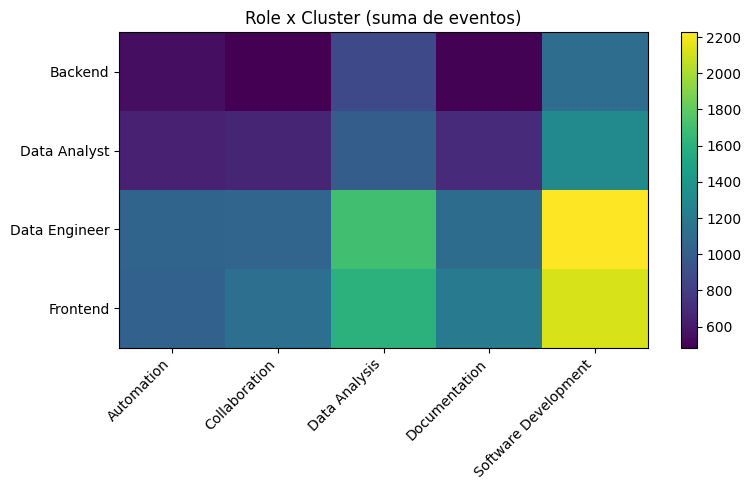

cluster                    Automation  Collaboration  Data Analysis  \
role          seniority                                               
Backend       Junior              168            152            311   
              Semi-Senior         140            181            248   
              Senior              243            151            312   
Data Analyst  Junior              259            211            296   
              Semi-Senior         316            337            530   
              Senior               69            113            172   
Data Engineer Junior              464            456            702   
              Semi-Senior         359            317            590   
              Senior              223            279            407   
Frontend      Junior              426            487            606   
              Semi-Senior         368            377            589   
              Senior              232            255            406   

cluster                    Documentation  Software Development  
role          seniority                                         
Backend       Junior                 140                   398  
              Semi-Senior            130                   295  
              Senior                 221                   412  
Data Analyst  Junior                 262                   453  
              Semi-Senior            281                   639  
              Senior                 151                   219  
Data Engineer Junior                 428                   943  
              Semi-Senior            392                   694  
              Senior                 282                   589  
Frontend      Junior                 514                   804  
              Semi-Senior            437                   833  
              Senior                 252                   481

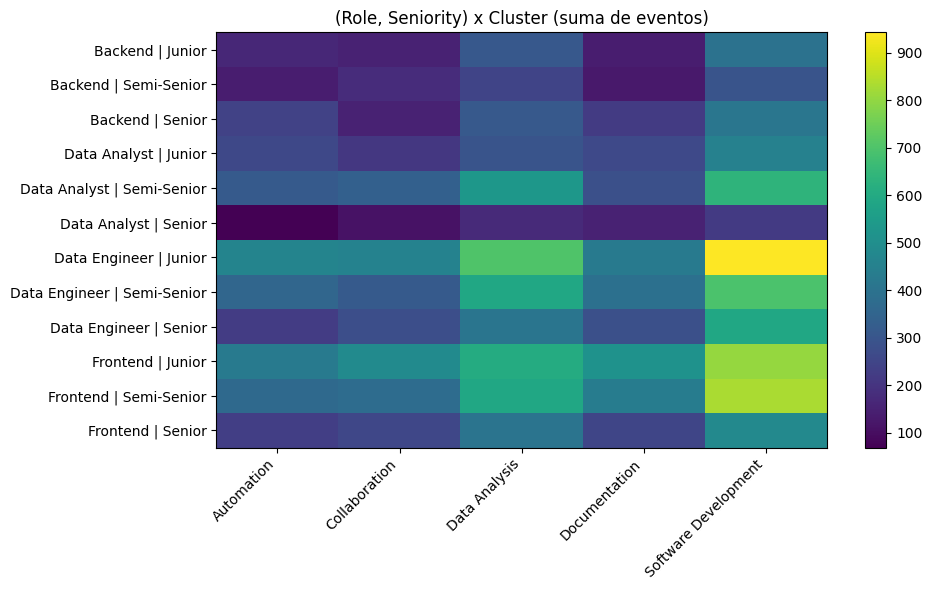

In [12]:

# Pivot: role x cluster
pivot_role_cluster = pd.pivot_table(
    df, index='role', columns='cluster', values='event_count', aggfunc='sum', fill_value=0
)
display(pivot_role_cluster)

plt.figure(figsize=(8, 5))
plt.imshow(pivot_role_cluster.values, aspect='auto')
plt.xticks(range(len(pivot_role_cluster.columns)), pivot_role_cluster.columns, rotation=45, ha='right')
plt.yticks(range(len(pivot_role_cluster.index)), pivot_role_cluster.index)
plt.title('Role x Cluster (suma de eventos)')
plt.colorbar()
plt.tight_layout()
plt.show()

# Pivot: (role, seniority) x cluster
pivot_r_s_cluster = pd.pivot_table(
    df, index=['role','seniority'], columns='cluster', values='event_count', aggfunc='sum', fill_value=0
).sort_index()
display(pivot_r_s_cluster)

plt.figure(figsize=(10, 6))
plt.imshow(pivot_r_s_cluster.values, aspect='auto')
plt.xticks(range(len(pivot_r_s_cluster.columns)), pivot_r_s_cluster.columns, rotation=45, ha='right')
plt.yticks(range(len(pivot_r_s_cluster.index)), [f"{r} | {s}" for r,s in pivot_r_s_cluster.index])
plt.title('(Role, Seniority) x Cluster (suma de eventos)')
plt.colorbar()
plt.tight_layout()
plt.show()



**Insight clave (perfil de usuario):**  
- Si ciertas métricas o clusters son **claramente mayores** en roles/seniorities específicos, esas señales **discriminan** y pueden recibir más peso en la ponderación.



## 5) Análisis de usuarios

**Métrica:** distribución de eventos por usuario  
**Salidas:** histograma (escala log) y boxplot  
**Qué buscar:** *power users* vs inactivos; relación volumen vs diversidad.


count    100.00000
mean     220.02000
std       33.89645
min      157.00000
25%      194.75000
50%      219.50000
75%      244.50000
max      312.00000
Name: event_count, dtype: float64

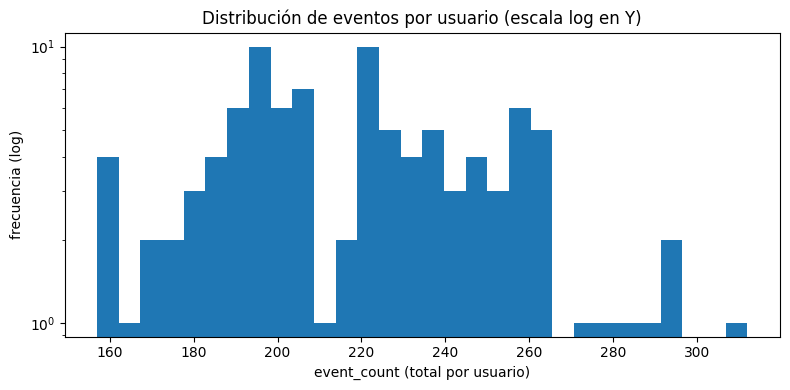

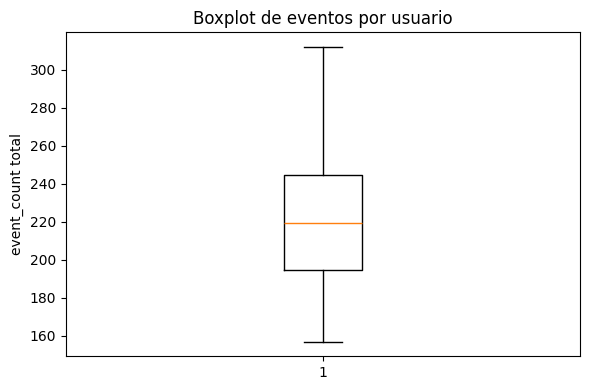

count    100.0
mean      13.0
std        0.0
min       13.0
25%       13.0
50%       13.0
75%       13.0
max       13.0
Name: metricas_distintas, dtype: float64

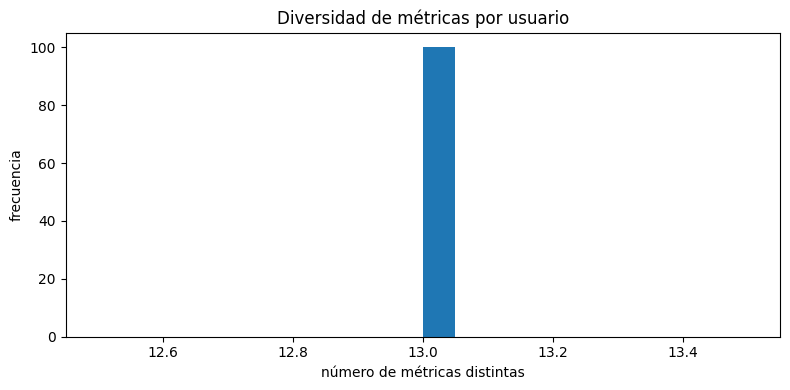

In [13]:

# Volumen por usuario
user_vol = df.groupby('user_id')['event_count'].sum().sort_values(ascending=False)
display(user_vol.describe())

plt.figure(figsize=(8,4))
plt.hist(user_vol.values, bins=30)
plt.yscale('log')
plt.title('Distribución de eventos por usuario (escala log en Y)')
plt.xlabel('event_count (total por usuario)')
plt.ylabel('frecuencia (log)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(user_vol.values, vert=True)
plt.title('Boxplot de eventos por usuario')
plt.ylabel('event_count total')
plt.tight_layout()
plt.show()

# Diversidad de métricas por usuario
user_div = df.groupby('user_id')['metric_name'].nunique().rename('metricas_distintas')
display(user_div.describe())

plt.figure(figsize=(8,4))
plt.hist(user_div.values, bins=20)
plt.title('Diversidad de métricas por usuario')
plt.xlabel('número de métricas distintas')
plt.ylabel('frecuencia')
plt.tight_layout()
plt.show()



**Insight clave (usuarios):**  
- Un subconjunto pequeño puede explicar la mayor parte del volumen (**power users**).  
- La **diversidad** de métricas por usuario es útil para estrategias de ponderación basadas en engagement/consistencia.



## 6) Correlación y redundancia entre métricas

**Métrica:** matriz de correlación (usuario x métrica) y **PCA** exploratoria  
**Salidas:** heatmap de correlación con `matplotlib` y varianza explicada por PCA  
**Qué buscar:** métricas redundantes vs independientes.


metric_name,builds,comments_left,commits,dashboards_created,deploys,docs_created,docs_edited,files_shared,jobs_scheduled,notebooks_modified,pull_requests,queries_executed,scripts_run
metric_name,,,,,,,,,,,,,
builds,1.000000,-0.108165,-0.002355,0.220564,-0.099653,0.047498,0.088611,0.024608,-0.053392,0.035878,-0.024475,-0.047779,0.044372
comments_left,-0.108165,1.000000,0.160531,0.076391,0.111043,0.048205,-0.062364,-0.061022,0.212429,-0.052010,-0.005723,0.000502,-0.075379
commits,-0.002355,0.160531,1.000000,0.075644,0.151594,-0.110300,-0.046577,0.034813,-0.010613,0.141244,0.057467,-0.014254,-0.019492
dashboards_created,0.220564,0.076391,0.075644,1.000000,0.061236,0.189500,-0.033475,-0.036482,-0.049032,0.079438,0.099386,0.164396,0.065495
deploys,-0.099653,0.111043,0.151594,0.061236,1.000000,-0.079248,0.116296,-0.118173,0.044176,0.048904,0.177059,0.064223,0.126939
docs_created,0.047498,0.048205,-0.110300,0.189500,-0.079248,1.000000,-0.242741,-0.071617,-0.144948,0.253478,0.016468,0.038580,0.052593
docs_edited,0.088611,-0.062364,-0.046577,-0.033475,0.116296,-0.242741,1.000000,0.151117,0.110978,-0.116164,0.066004,-0.098716,0.088678
files_shared,0.024608,-0.061022,0.034813,-0.036482,-0.118173,-0.071617,0.151117,1.000000,-0.064745,-0.061604,-0.161092,0.067753,-0.056695
jobs_scheduled,-0.053392,0.212429,-0.010613,-0.049032,0.044176,-0.144948,0.110978,-0.064745,1.000000,-0.169013,-0.061160,0.043757,0.052333


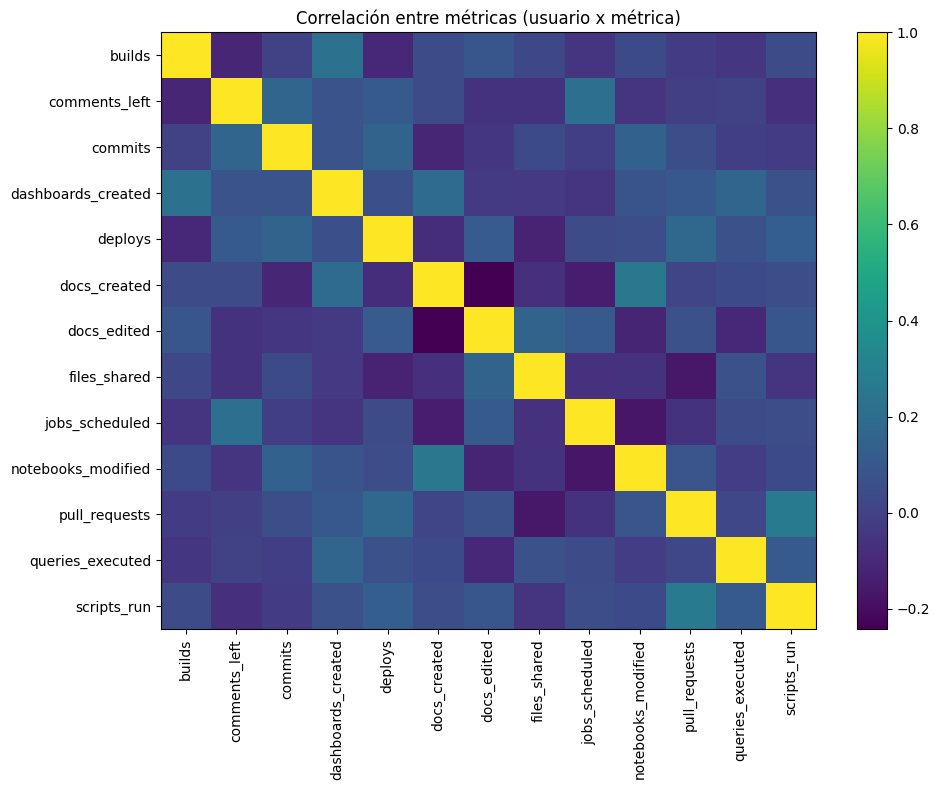

Varianza explicada acumulada (primeros 10 componentes):
[0.12980709 0.24951192 0.35429124 0.4467612  0.5369835  0.61947689
 0.68685464 0.7509622  0.81276578 0.86598656]


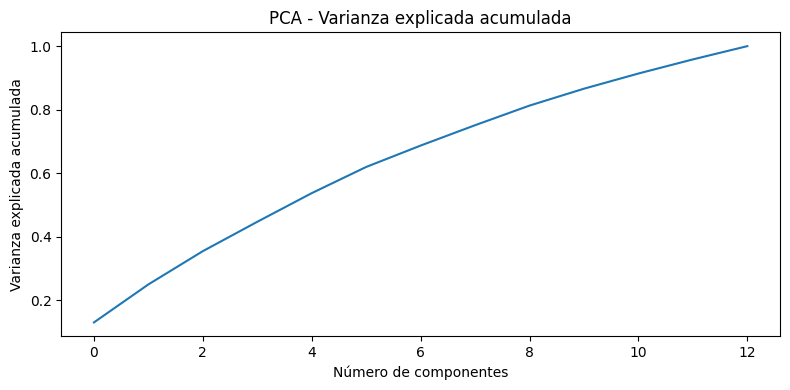

In [14]:

# Matriz usuario x métrica
user_metric = pd.pivot_table(
    df, index='user_id', columns='metric_name', values='event_count', aggfunc='sum', fill_value=0
)

# Correlación entre métricas
corr = user_metric.corr()
display(corr)

plt.figure(figsize=(10,8))
plt.imshow(corr.values, aspect='auto', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlación entre métricas (usuario x métrica)')
plt.colorbar()
plt.tight_layout()
plt.show()

# PCA exploratorio (opcional)
try:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    X = user_metric.values.astype(float)
    X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    pca = PCA()
    pca.fit(X_scaled)

    var_ratio = pca.explained_variance_ratio_
    print("Varianza explicada acumulada (primeros 10 componentes):")
    print(np.cumsum(var_ratio)[:10])

    plt.figure(figsize=(8,4))
    plt.plot(np.cumsum(var_ratio))
    plt.xlabel('Número de componentes')
    plt.ylabel('Varianza explicada acumulada')
    plt.title('PCA - Varianza explicada acumulada')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("PCA no disponible o falló la ejecución:", e)



**Insight clave (correlación/PCA):**  
- Pares de métricas con **alta correlación** son candidatos a **reducción o menor peso relativo**.  
- Si pocas componentes explican gran parte de la varianza, el espacio de métricas puede **reducirse** o reponderarse.
